##Introduction

The project is about AI chatbot which provides the user with course information based on relevant questions. The chatbot machine learning model uses LSTM. The bot business logic is deployed on the Django based backend and is made availabel through a React based frontend to the user.

###Data collection through Python Scrapy web scraping

Python scrapy spider is used to scrape (collect data) from the https://www.ontariocolleges.ca/en/colleges/loyalist website and store the courses information in a MongoDB database.

Below is a screenshot of part of the scrapy spider that extracts DOM elements using xpath method

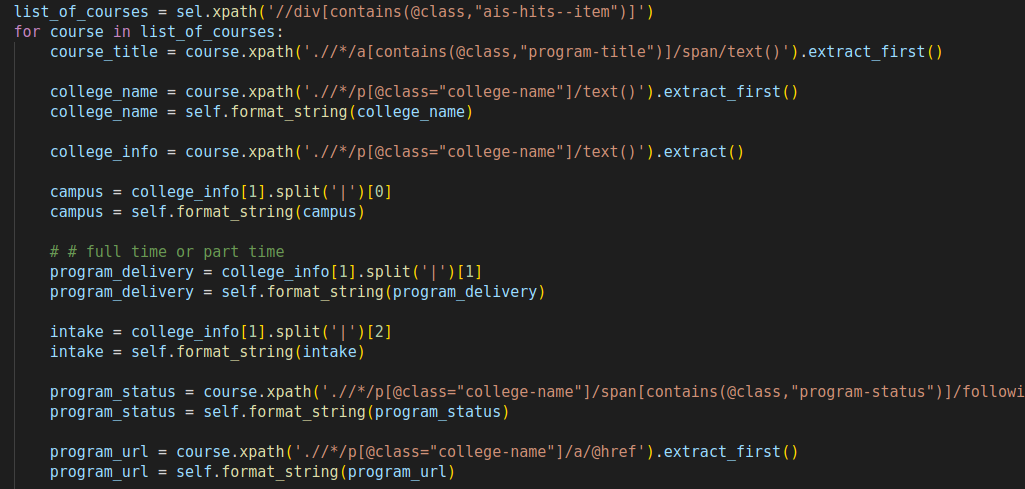 



The codebase for the scrapy spider can be found here:
https://github.com/shivrajd3/lchatbot_spider

### Intent file Generator

The intent file generator python script is used to generate a corpus in the format that can be served as an input to the machine learning model.

A part of the code logic that is used to extract the courses information and generate the intent file is as below

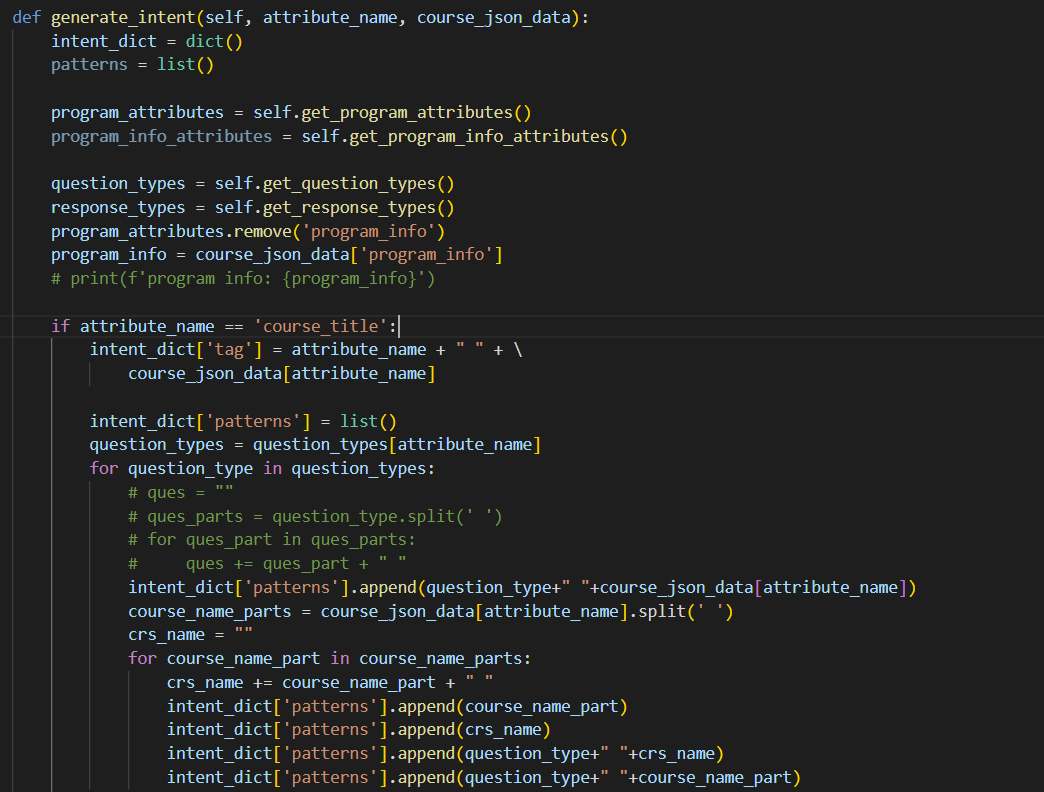

The codebase for the Intent File Generator tool can be found in the tools directory here
https://github.com/shivrajd3/lchatbotrepo

### The Chatbot NLP Model

The model below forms the brain of the AI Chatbot which uses LSTM (Long Short-Term Memory, a type of RNN) which is capable of allowing the sequence of words to persist.

In [14]:
#importing the libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalMaxPooling1D, Flatten, Dropout
from tensorflow.keras.models import Model
import string
import matplotlib.pyplot as plt

The training phase of the model begins with loading the Intents JSON file that was generated by the Intent File Generator tool. 

In [8]:
#importing the dataset
# with open('content.json') as content:
with open('Intent - loyalist.json') as content:
  data1 = json.load(content)

#getting all the data to lists
tags = []
inputs = []
responses={}
for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])

data = pd.DataFrame({"inputs":inputs,
                     "tags":tags})
# data = data.sample(frac=1)

The user input patterns and the tags both form the features to train the model. Firstly, the features corpus is tokenized using Keras Tokenizer and then the method ‘fit_on_texts’ is called on the tokenizer object that creates the vocabulary index based on the corpus.

This is then followed with applying ‘texts_to_sequences’ on the data to convert texts to a sequence of integers to enable computer to better understand the data.

We then call the ‘pad_sequences’ on the data to make the sequences array of same lengths. This is because the machine learning model expects the input sequence of same length.

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['inputs'])
train = tokenizer.texts_to_sequences(data['inputs'])
#apply padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(train)

On the labels parts of the data, we use LabelEncoder class from keras and apply fit_transform method on the ‘tags’ part of the data to convert the label or target data into values between 0 and (n number of classes -1)

In [10]:
#encoding the outputs
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

input_shape = x_train.shape[1]
print(input_shape)


16


We create the model architecture using Functional API implementation of Tensorflow.
The first layer is the Embedding layer. Here the words and sequences of words are converted into dense vectors so that the most related or relevant words are close to each other in a 3 dimensional vector space. 

The model’s next layer is an LSTM (Long Short-Term Memory) layer. LSTM is a child of RNN (recurrent neural network) but addresses its drawback of vanishing gradient. LSTM helps retain the sequence of words which is very important when making sense of the user queries or questions that the chatbot will encounter.

The final layer of our model is the Dense output layer with softmax activation to cater to multiple classes prediction in our output.


In [11]:
vocabulary = len(tokenizer.word_index)
print("number of unique words : ",vocabulary)
output_length = le.classes_.shape[0]
print("output length: ",output_length)

i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,10)(i)
# x = Dense(128, input_shape=(input_shape,), activation='relu')(x)
# # x = Dropout(0.2)(x)
# x = Dense(64, input_shape=(input_shape,), activation='relu')(x)
# # x = Dropout(0.2)(x)
# x = Dense(32, input_shape=(input_shape,), activation='relu')(x)
# x = Dropout(0.2)(x)
x = LSTM(30,return_sequences=True)(x)
x = Flatten()(x)
x = Dense(output_length,activation="softmax")(x)
model  = Model(i,x)

number of unique words :  225
output length:  82


The model is compiled using Adam optimizer and loss function of sparse categorical crossentropy

We train the model for 100 epochs. 
After 100 epochs, The model reaches an accuracy score of around 69% with loss of around 90%.


In [12]:
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

train = model.fit(x_train,y_train,epochs=100)

Epoch 1/100
324/324 [==============================] - 19s 32ms/step - loss: 4.2298 - accuracy: 0.0377
Epoch 2/100
324/324 [==============================] - 3s 8ms/step - loss: 3.1929 - accuracy: 0.2608
Epoch 3/100
324/324 [==============================] - 2s 6ms/step - loss: 2.1740 - accuracy: 0.5370
Epoch 4/100
324/324 [==============================] - 2s 5ms/step - loss: 1.6798 - accuracy: 0.6462
Epoch 5/100
324/324 [==============================] - 2s 5ms/step - loss: 1.4166 - accuracy: 0.6764
Epoch 6/100
324/324 [==============================] - 2s 5ms/step - loss: 1.2657 - accuracy: 0.6861
Epoch 7/100
324/324 [==============================] - 2s 7ms/step - loss: 1.1728 - accuracy: 0.6861
Epoch 8/100
324/324 [==============================] - 1s 4ms/step - loss: 1.1141 - accuracy: 0.6865
Epoch 9/100
324/324 [==============================] - 2s 6ms/step - loss: 1.0705 - accuracy: 0.6896
Epoch 10/100
324/324 [==============================] - 1s 5ms/step - loss: 1.0396 - accu

When predicting the class and generating bot response, first we begin with cleaning and pre-processing the user input data into series of steps like tokenization, texts_to_sequences and padding the sequences. 
The predict method of the model is then applied to the cleaned and pre-formatted user input data to predict the output class.
The LabelEncoder inverse_transform method gives a way to get the text values of the labels based on the previously encoded integer values.


#### Model analysis

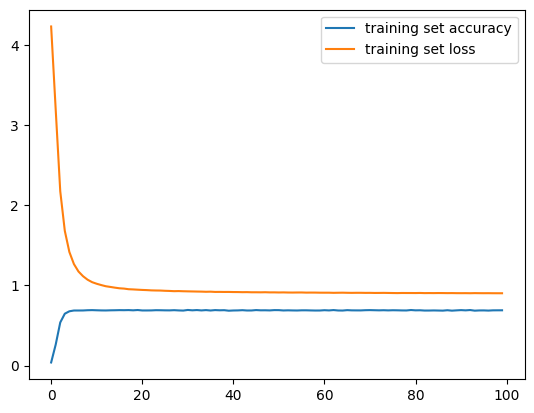

In [15]:
plt.plot(train.history['accuracy'],label='training set accuracy')
plt.plot(train.history['loss'],label='training set loss')
plt.legend()

In [21]:
import random

count = 0
questions = ['who are you', 'can you help me', 'do you teach data science', 'tell me about sports', 'thank you']
for question in questions:
  print("----------------")
  print(f"User : {question}")
  texts_p = []
  prediction_input = question

  #removing punctuation and converting to lowercase
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  #tokenizing and padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  #getting output from model
  output = model.predict(prediction_input)
  output = output.argmax()

  #finding the right tag and predicting
  response_tag = le.inverse_transform([output])[0]
  print("LChatBot : ",random.choice(responses[response_tag]))
  print("----------------")

----------------
User : who are you
1/1 [==============================] - 0s 20ms/step
LChatBot :  I am LChatBot, I can help you with any questions or concerns you may have.
----------------
----------------
User : can you help me
1/1 [==============================] - 0s 18ms/step
LChatBot :  Sure, I'd be happy to help.
----------------
----------------
User : do you teach data science
1/1 [==============================] - 0s 17ms/step
LChatBot :  {'response': {'message': 'does this help?', 'course_details': {'course_title': 'Artificial Intelligence & Data Science ', 'college_name': 'Loyalist', 'campus': 'Main', 'program_delivery': 'Full Time', 'intake': 'Sep 2023', 'program_status': 'Open', 'program_url': 'https://www.loyalistcollege.com/programs-and-courses/full-time-programs/artificial-intelligence-and-data-science/'}, 'program_info': {'Program Length:': '2 Semesters', 'Program Code:': 'AIGS', 'Credential:': 'Graduate Certificate', 'Program Level:': 'Post-Secondary', 'Program Typ

### Django web application with API - Backend

Django is a high-level python web framework for fast web development. It also provides Django REST a toolkit to build web APIs. 
The chatbot backend is built using Django and hosted on a VPS server.
The backend consists of two main apps namely ‘bot’ and ‘botapi’. 
The bot app is where all the business logic regarding the training the model and generating user response is located. It consists of two main methods called train_model and generate_response.
The train_model method forms the training phase where it trains and saves the NLP model. This method is to be called the first time to generate and save the NLP model and thereafter can be called whenever there are any changes or optimizations in either the model architecture or the Intents JSON file.
The generate_response method forms the interaction phase where it takes in a text (ideally a query from the user) and generates the bot response to be sent back to the user.


Here is a part of the code implemented for 'train_model' function on the django application

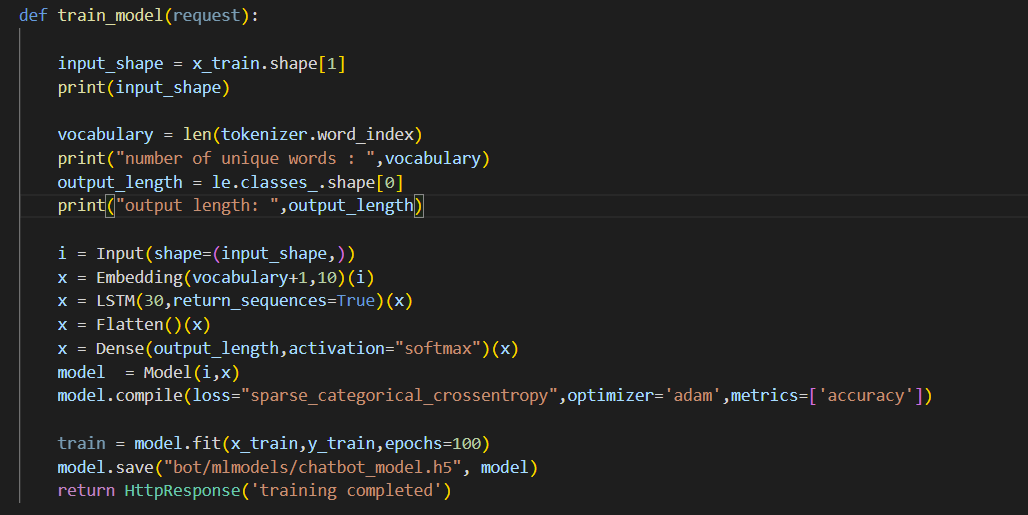

The entire codebase for the Django Application and API can be found here:
https://github.com/shivrajd3/lchatbotrepo

### React web application - The frontend

React is one of the most popular a javascript framework for creating web interfaces. It provides features such as virtual DOMs and reusable components to cut down development time and built a UI efficiently. It also helps easier state management of the web elements as compared to vanilla javascript.
On the frontend, the react based web application chatbot widget looks like this (just like any other chat widget but powered with our NLP based AI Chatbot).


The frontend UI of the Chatbot widget developed using React Framework looks like this

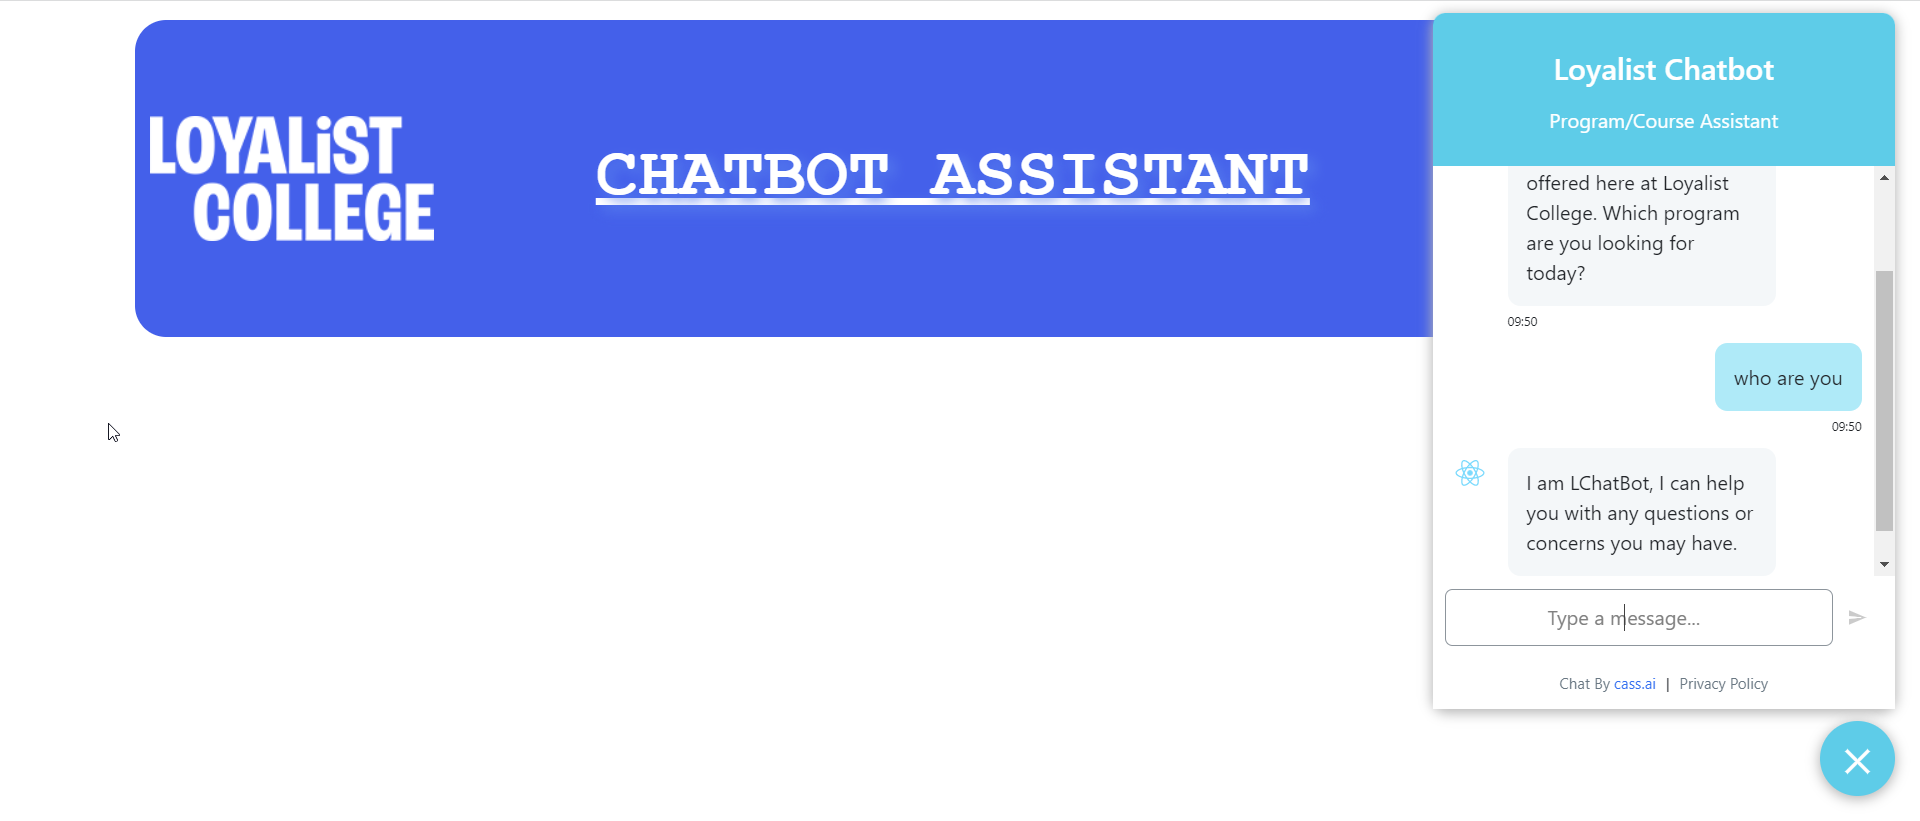

The entire codebase for the React application that implements the Chatbot UI can be found here: https://github.com/Nonso-Ukwuma/chatbot

### Conclusion

This project gives an end-to-end lifecycle of NLP ML model including data extraction, data cleansing and pre-processing, model training and its implementation for a real production use on a cloud-based web server with its capabilities consumed over a frontend user facing application.

### References

https://stackoverflow.com/questions/51956000/what-does-keras-tokenizer-method-exactly-do
https://machinelearningknowledge.ai/keras-tokenizer-tutorial-with-examples-for-fit_on_texts-texts_to_sequences-texts_to_matrix-sequences_to_matrix/
https://medium.com/analytics-vidhya/understanding-nlp-keras-tokenizer-class-arguments-with-example-551c100f0cbd
https://ekababisong.org/gcp-ml-seminar/scikit-learn/
https://torontoai.org/2019/12/07/multi-class-text-classification-with-lstm-using-tensorflow-2-0/